# Maximum Likelihood Estimation of a multivariate Gaussian model

The goal of this notebook is to use PyTorch to implement Gradient-based MLE for a multivariate Gaussian model.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Single 2D Gaussian component

Let's generate a some data by sampling a multivariate Gaussian with an arbitrary covariance matrix:

In [2]:
rng = np.random.RandomState(42)
n_features = 2

mean = rng.randn(n_features)
mean

array([ 0.49671415, -0.1382643 ])

In [3]:
h = rng.randn(n_features, n_features)
Cov = h @ h.T
Cov

array([[ 2.73912039, -0.50825603],
       [-0.50825603,  0.10964792]])

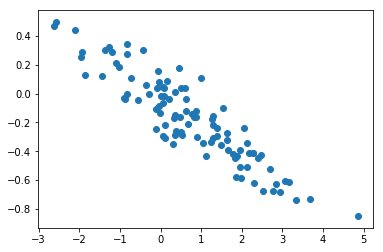

In [4]:
n_samples = 100
data = rng.multivariate_normal(mean, Cov, size=n_samples)
plt.scatter(data[:, 0], data[:, 1]);

Let's compute the MLE estimate from this data using the closed-form formula:

In [5]:
mu_mle = data.mean(axis=0)
mu_mle

array([ 0.70263098, -0.17305392])

In [6]:
Cov_mle = (data - mu_mle).T @ (data - mu_mle) / n_samples
Cov_mle

array([[ 2.0476404 , -0.38824024],
       [-0.38824024,  0.08873728]])

## Parametrisation of a positive definite matrix


Let's parametrize the precision matrix `P` (inverse of a covariance matrix `C`) as follows:

- `P` has Cholesky decomposition `H`
- `H` is a lower triangular with a positive diagonal
- the log of the diagonal entry is stored in a vector of parameters named `d`
- the off diagonal elements of `H` are stored in the matrix of parameters named `W`

In [7]:
import torch
from torch.autograd import Variable

d = Variable(torch.ones(n_features))
W = Variable(torch.randn(n_features, n_features))
H = torch.diag(torch.exp(d)) + torch.tril(W, -1)
P = H @ H.transpose(1, 0)
P

Variable containing:
 7.3891  1.1963
 1.1963  7.5827
[torch.FloatTensor of size 2x2]

Let's check that H is the actual Cholesky decomposition of P:

In [8]:
H.data.numpy()

array([[ 2.71828175,  0.        ],
       [ 0.44010174,  2.71828175]], dtype=float32)

In [9]:
np.linalg.cholesky(P.data.numpy())

array([[ 2.71828175,  0.        ],
       [ 0.44010174,  2.71828175]], dtype=float32)

`P` is positive semi-definite by construction (product of a matrix `H` by its transposed).

Because of we take the `exp` of `d` to build the diagonal elements of `H`, the determinant of `H` and therefore `P` is stricly positive.

`P` is therefore is positive definite, whatever the values the parameters in `d` and `W`. Because the Cholesky decomposition is unique, this paramtrization of the manifold of positive definite matrices is bijective.

In [10]:
np.linalg.det(P.data.numpy())

54.598145

In [11]:
np.linalg.det(H.data.numpy()) ** 2

54.598144564972472

The determinant of `P` is cheap to compute from the `d` parameters directly:

In [12]:
torch.prod(torch.exp(d.data) ** 2)

54.59814456497247

Let's use the above function to define the log-likelihood of a Gaussian model: